In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='4'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='min_temp'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_4_20250327_0313


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 294557/294557 [01:08<00:00, 4271.90it/s]

Saved 294557 profiles to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/20250327-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 294557it [00:11, 25971.57it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/density_plot.png


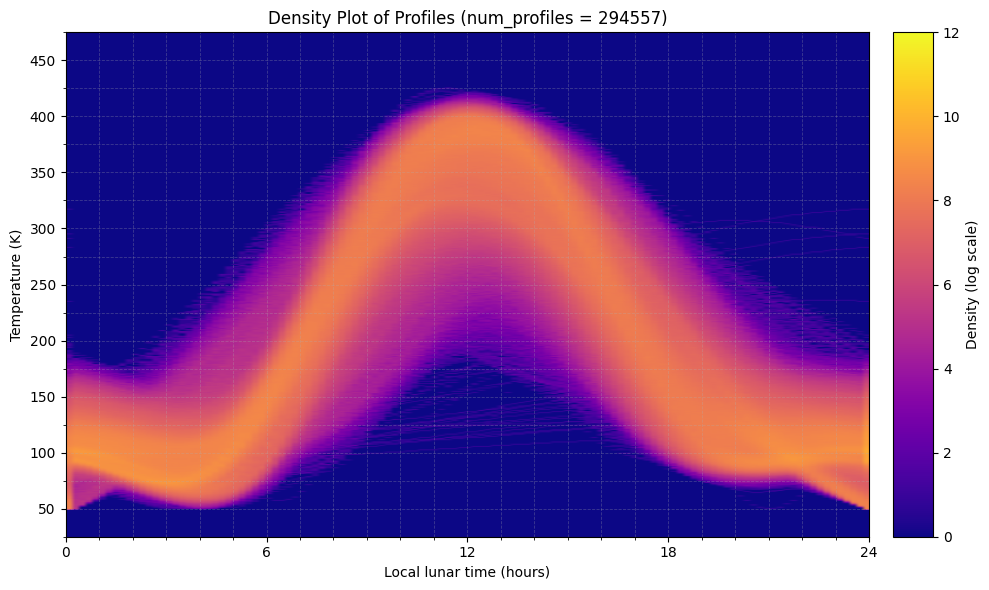

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/histogram_max_temp.png


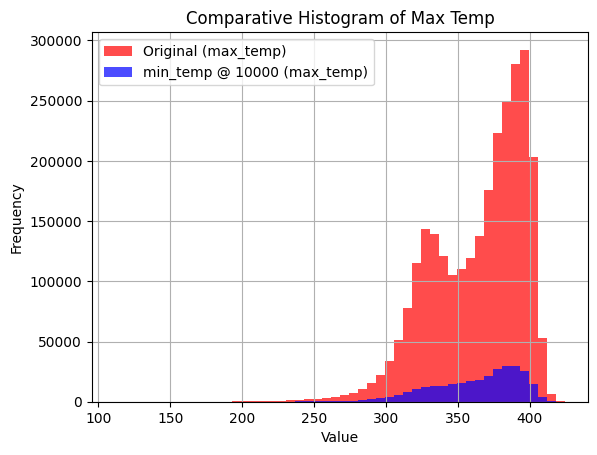

Saved figure to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/histogram_min_temp.png


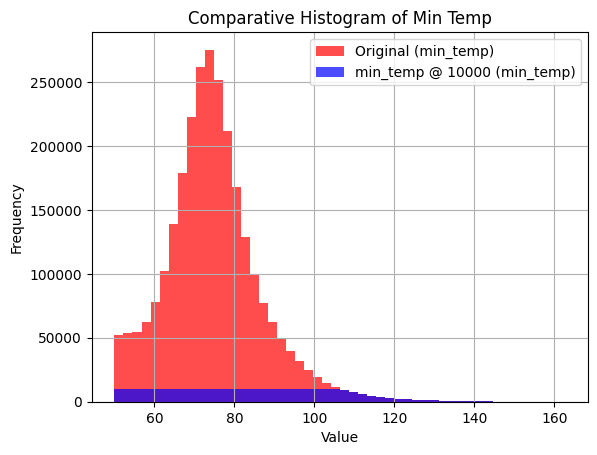

Saved figure to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/histogram_mean_temp.png


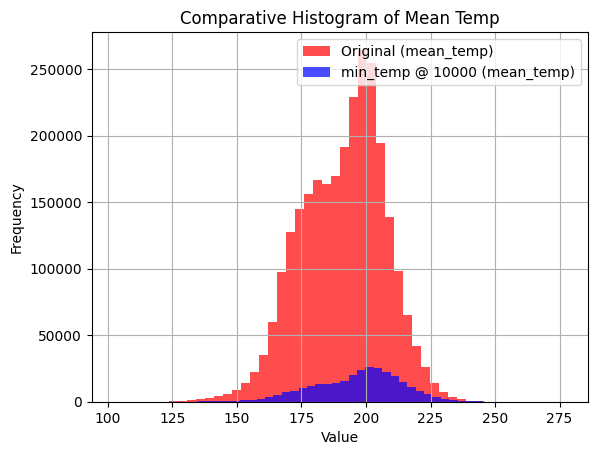

Saved figure to /workspace/outputs/profiles_v1_experiment_4_20250327_0313/histogram_std_temp.png


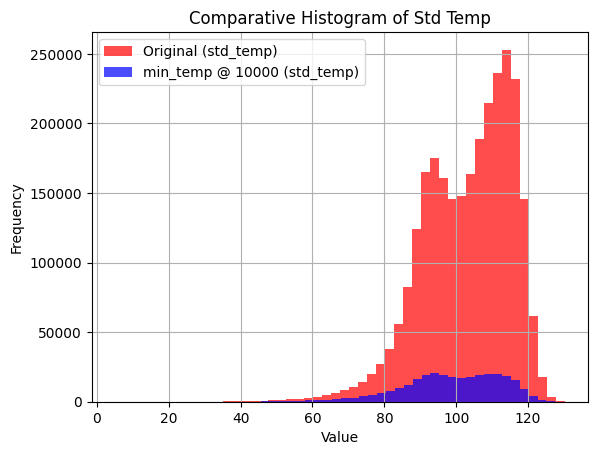

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.7734
STD: 101.0048
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 206189
Validation Data: 58911
Test Data: 29457


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.74it/s, best_loss=0.6137]


[Training] Epoch 1/100, L1 Loss: 0.6116, L2 Loss: 0.6507, KL Loss: 0.5412, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 295/295 [00:02<00:00, 104.31it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5427, Val L2 Loss: 0.5574, Val KL Loss: 0.5999
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_4_20250327_0313'


[Training] Epoch 2/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.03it/s, best_loss=0.6047]


[Training] Epoch 2/100, L1 Loss: 0.5790, L2 Loss: 0.6026, KL Loss: 0.6086, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 295/295 [00:02<00:00, 104.36it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5479, Val KL Loss: 0.6213
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_4_20250327_0313'


[Training] Epoch 3/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.02it/s, best_loss=0.5669]


[Training] Epoch 3/100, L1 Loss: 0.5772, L2 Loss: 0.6006, KL Loss: 0.6137, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 295/295 [00:02<00:00, 106.00it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5515, Val KL Loss: 0.6041


[Training] Epoch 4/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.25it/s, best_loss=0.6026]


[Training] Epoch 4/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 295/295 [00:02<00:00, 100.84it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5334, Val L2 Loss: 0.5499, Val KL Loss: 0.6109


[Training] Epoch 5/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.03it/s, best_loss=0.5808]


[Training] Epoch 5/100, L1 Loss: 0.5773, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 295/295 [00:02<00:00, 99.13it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5493, Val KL Loss: 0.6106


[Training] Epoch 6/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.05it/s, best_loss=0.5972]


[Training] Epoch 6/100, L1 Loss: 0.5774, L2 Loss: 0.6009, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 295/295 [00:02<00:00, 100.00it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5485, Val KL Loss: 0.6102


[Training] Epoch 7/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.71it/s, best_loss=0.6029]


[Training] Epoch 7/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 295/295 [00:02<00:00, 113.51it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5497, Val KL Loss: 0.6087


[Training] Epoch 8/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.89it/s, best_loss=0.5985]


[Training] Epoch 8/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 295/295 [00:02<00:00, 113.44it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5466, Val KL Loss: 0.6199
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_4_20250327_0313'


[Training] Epoch 9/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.25it/s, best_loss=0.5991]


[Training] Epoch 9/100, L1 Loss: 0.5771, L2 Loss: 0.6004, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 295/295 [00:02<00:00, 116.74it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5350, Val L2 Loss: 0.5511, Val KL Loss: 0.6046


[Training] Epoch 10/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.33it/s, best_loss=0.6156]


[Training] Epoch 10/100, L1 Loss: 0.5772, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 295/295 [00:02<00:00, 113.33it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5361, Val L2 Loss: 0.5519, Val KL Loss: 0.6036


[Training] Epoch 11/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.00it/s, best_loss=0.5870]


[Training] Epoch 11/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 295/295 [00:02<00:00, 110.36it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5488, Val KL Loss: 0.6155


[Training] Epoch 12/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.59it/s, best_loss=0.5890]


[Training] Epoch 12/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 295/295 [00:02<00:00, 110.20it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5478, Val KL Loss: 0.6140


[Training] Epoch 13/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.90it/s, best_loss=0.5924]


[Training] Epoch 13/100, L1 Loss: 0.5776, L2 Loss: 0.6009, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 295/295 [00:02<00:00, 117.92it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5499, Val KL Loss: 0.6075


[Training] Epoch 14/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.74it/s, best_loss=0.5968]


[Training] Epoch 14/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 295/295 [00:02<00:00, 112.15it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5484, Val KL Loss: 0.6107


[Training] Epoch 15/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.96it/s, best_loss=0.5961]


[Training] Epoch 15/100, L1 Loss: 0.5777, L2 Loss: 0.6011, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 295/295 [00:02<00:00, 112.73it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5492, Val KL Loss: 0.6094


[Training] Epoch 16/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.59it/s, best_loss=0.5986]


[Training] Epoch 16/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 295/295 [00:02<00:00, 116.28it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5490, Val KL Loss: 0.6094


[Training] Epoch 17/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.65it/s, best_loss=0.6009]


[Training] Epoch 17/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 295/295 [00:02<00:00, 115.02it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5497, Val KL Loss: 0.6101


[Training] Epoch 18/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.06it/s, best_loss=0.6024]


[Training] Epoch 18/100, L1 Loss: 0.5774, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 295/295 [00:02<00:00, 114.87it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5477, Val KL Loss: 0.6148


[Training] Epoch 19/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.66it/s, best_loss=0.5717]


[Training] Epoch 19/100, L1 Loss: 0.5774, L2 Loss: 0.6007, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 295/295 [00:02<00:00, 110.65it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5502, Val KL Loss: 0.6083


[Training] Epoch 20/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.91it/s, best_loss=0.6086]


[Training] Epoch 20/100, L1 Loss: 0.5772, L2 Loss: 0.6006, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 295/295 [00:02<00:00, 119.40it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5386, Val L2 Loss: 0.5537, Val KL Loss: 0.5988


[Training] Epoch 21/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.83it/s, best_loss=0.5963]


[Training] Epoch 21/100, L1 Loss: 0.5774, L2 Loss: 0.6006, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 295/295 [00:02<00:00, 116.14it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5502, Val KL Loss: 0.6077


[Training] Epoch 22/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.70it/s, best_loss=0.6062]


[Training] Epoch 22/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 295/295 [00:02<00:00, 111.35it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5487, Val KL Loss: 0.6139


[Training] Epoch 23/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.83it/s, best_loss=0.5956]


[Training] Epoch 23/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 295/295 [00:02<00:00, 112.29it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5490, Val KL Loss: 0.6103


[Training] Epoch 24/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.63it/s, best_loss=0.6043]


[Training] Epoch 24/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 295/295 [00:02<00:00, 111.03it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5503, Val KL Loss: 0.6072


[Training] Epoch 25/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.11it/s, best_loss=0.5968]


[Training] Epoch 25/100, L1 Loss: 0.5775, L2 Loss: 0.6010, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 295/295 [00:02<00:00, 110.23it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5504, Val KL Loss: 0.6067


[Training] Epoch 26/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.40it/s, best_loss=0.5840]


[Training] Epoch 26/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 295/295 [00:02<00:00, 112.05it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5481, Val KL Loss: 0.6159


[Training] Epoch 27/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.70it/s, best_loss=0.6077]


[Training] Epoch 27/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 295/295 [00:02<00:00, 117.30it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5501, Val KL Loss: 0.6076


[Training] Epoch 28/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.85it/s, best_loss=0.5936]


[Training] Epoch 28/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 295/295 [00:02<00:00, 114.64it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5483, Val KL Loss: 0.6167


[Training] Epoch 29/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.74it/s, best_loss=0.6003]


[Training] Epoch 29/100, L1 Loss: 0.5774, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 295/295 [00:02<00:00, 114.58it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5478, Val KL Loss: 0.6178


[Training] Epoch 30/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.06it/s, best_loss=0.6136]


[Training] Epoch 30/100, L1 Loss: 0.5774, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 295/295 [00:02<00:00, 110.59it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5506, Val KL Loss: 0.6048


[Training] Epoch 31/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.86it/s, best_loss=0.5810]


[Training] Epoch 31/100, L1 Loss: 0.5772, L2 Loss: 0.6004, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 295/295 [00:02<00:00, 112.16it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5503, Val KL Loss: 0.6080


[Training] Epoch 32/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.23it/s, best_loss=0.6077]


[Training] Epoch 32/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 295/295 [00:02<00:00, 117.52it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5494, Val KL Loss: 0.6083


[Training] Epoch 33/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.02it/s, best_loss=0.5868]


[Training] Epoch 33/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 295/295 [00:02<00:00, 109.06it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5491, Val KL Loss: 0.6104


[Training] Epoch 34/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.64it/s, best_loss=0.6104]


[Training] Epoch 34/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 295/295 [00:02<00:00, 111.75it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5499, Val KL Loss: 0.6140


[Training] Epoch 35/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.25it/s, best_loss=0.6036]


[Training] Epoch 35/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 295/295 [00:02<00:00, 119.45it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5495, Val KL Loss: 0.6126


[Training] Epoch 36/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.63it/s, best_loss=0.5799]


[Training] Epoch 36/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 295/295 [00:02<00:00, 115.52it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5462, Val KL Loss: 0.6241
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_4_20250327_0313'


[Training] Epoch 37/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.11it/s, best_loss=0.5714]


[Training] Epoch 37/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 295/295 [00:02<00:00, 115.86it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5506, Val KL Loss: 0.6046


[Training] Epoch 38/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.84it/s, best_loss=0.6068]


[Training] Epoch 38/100, L1 Loss: 0.5775, L2 Loss: 0.6009, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 295/295 [00:02<00:00, 116.10it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5487, Val KL Loss: 0.6158


[Training] Epoch 39/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.27it/s, best_loss=0.5790]


[Training] Epoch 39/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 295/295 [00:02<00:00, 116.32it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5480, Val KL Loss: 0.6172


[Training] Epoch 40/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.55it/s, best_loss=0.6109]


[Training] Epoch 40/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 295/295 [00:02<00:00, 112.81it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5334, Val L2 Loss: 0.5500, Val KL Loss: 0.6107


[Training] Epoch 41/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.96it/s, best_loss=0.5878]


[Training] Epoch 41/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 295/295 [00:02<00:00, 114.76it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5387, Val L2 Loss: 0.5539, Val KL Loss: 0.6003


[Training] Epoch 42/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.51it/s, best_loss=0.6054]


[Training] Epoch 42/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 295/295 [00:02<00:00, 114.11it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5515, Val KL Loss: 0.6066


[Training] Epoch 43/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.86it/s, best_loss=0.5815]


[Training] Epoch 43/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 295/295 [00:02<00:00, 113.99it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5496, Val KL Loss: 0.6122


[Training] Epoch 44/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.27it/s, best_loss=0.5906]


[Training] Epoch 44/100, L1 Loss: 0.5773, L2 Loss: 0.6008, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 295/295 [00:02<00:00, 110.70it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5363, Val L2 Loss: 0.5519, Val KL Loss: 0.6040


[Training] Epoch 45/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.97it/s, best_loss=0.5950]


[Training] Epoch 45/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 295/295 [00:02<00:00, 112.05it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5505, Val KL Loss: 0.6065


[Training] Epoch 46/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.80it/s, best_loss=0.6045]


[Training] Epoch 46/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 295/295 [00:02<00:00, 113.46it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5349, Val L2 Loss: 0.5510, Val KL Loss: 0.6070


[Training] Epoch 47/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.94it/s, best_loss=0.5828]


[Training] Epoch 47/100, L1 Loss: 0.5775, L2 Loss: 0.6011, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 295/295 [00:02<00:00, 117.50it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5514, Val KL Loss: 0.6040


[Training] Epoch 48/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.05it/s, best_loss=0.5820]


[Training] Epoch 48/100, L1 Loss: 0.5775, L2 Loss: 0.6009, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 295/295 [00:02<00:00, 110.73it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5493, Val KL Loss: 0.6111


[Training] Epoch 49/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.07it/s, best_loss=0.5830]


[Training] Epoch 49/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 295/295 [00:02<00:00, 118.79it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5486, Val KL Loss: 0.6155


[Training] Epoch 50/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.37it/s, best_loss=0.5974]


[Training] Epoch 50/100, L1 Loss: 0.5775, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 295/295 [00:02<00:00, 113.94it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5489, Val KL Loss: 0.6097


[Training] Epoch 51/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.71it/s, best_loss=0.5860]


[Training] Epoch 51/100, L1 Loss: 0.5774, L2 Loss: 0.6009, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 295/295 [00:02<00:00, 111.22it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5488, Val KL Loss: 0.6131


[Training] Epoch 52/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.66it/s, best_loss=0.6028]


[Training] Epoch 52/100, L1 Loss: 0.5776, L2 Loss: 0.6009, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 295/295 [00:02<00:00, 111.75it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5516, Val KL Loss: 0.6024


[Training] Epoch 53/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.89it/s, best_loss=0.5883]


[Training] Epoch 53/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 295/295 [00:02<00:00, 114.23it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5487, Val KL Loss: 0.6109


[Training] Epoch 54/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.26it/s, best_loss=0.5912]


[Training] Epoch 54/100, L1 Loss: 0.5772, L2 Loss: 0.6004, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 295/295 [00:02<00:00, 114.43it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5332, Val L2 Loss: 0.5497, Val KL Loss: 0.6074


[Training] Epoch 55/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.67it/s, best_loss=0.5805]


[Training] Epoch 55/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 295/295 [00:02<00:00, 119.49it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5486, Val KL Loss: 0.6143


[Training] Epoch 56/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.07it/s, best_loss=0.5972]


[Training] Epoch 56/100, L1 Loss: 0.5776, L2 Loss: 0.6011, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 295/295 [00:02<00:00, 112.14it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5489, Val KL Loss: 0.6115


[Training] Epoch 57/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.61it/s, best_loss=0.6038]


[Training] Epoch 57/100, L1 Loss: 0.5773, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 295/295 [00:02<00:00, 115.03it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5496, Val KL Loss: 0.6083


[Training] Epoch 58/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.80it/s, best_loss=0.5905]


[Training] Epoch 58/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 295/295 [00:02<00:00, 110.96it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5506, Val KL Loss: 0.6054


[Training] Epoch 59/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.80it/s, best_loss=0.5940]


[Training] Epoch 59/100, L1 Loss: 0.5773, L2 Loss: 0.6008, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 295/295 [00:02<00:00, 115.13it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5467, Val KL Loss: 0.6216


[Training] Epoch 60/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.04it/s, best_loss=0.5967]


[Training] Epoch 60/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 295/295 [00:02<00:00, 103.81it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5493, Val KL Loss: 0.6071


[Training] Epoch 61/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.97it/s, best_loss=0.5771]


[Training] Epoch 61/100, L1 Loss: 0.5772, L2 Loss: 0.6007, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 295/295 [00:02<00:00, 111.39it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5506, Val KL Loss: 0.6060


[Training] Epoch 62/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.23it/s, best_loss=0.5795]


[Training] Epoch 62/100, L1 Loss: 0.5774, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 295/295 [00:02<00:00, 112.56it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5476, Val KL Loss: 0.6150


[Training] Epoch 63/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.87it/s, best_loss=0.6080]


[Training] Epoch 63/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 295/295 [00:02<00:00, 112.56it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5345, Val L2 Loss: 0.5507, Val KL Loss: 0.6068


[Training] Epoch 64/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.74it/s, best_loss=0.6015]


[Training] Epoch 64/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 295/295 [00:02<00:00, 114.78it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5464, Val KL Loss: 0.6216


[Training] Epoch 65/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.10it/s, best_loss=0.5917]


[Training] Epoch 65/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 295/295 [00:02<00:00, 111.94it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5471, Val KL Loss: 0.6169


[Training] Epoch 66/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.80it/s, best_loss=0.5736]


[Training] Epoch 66/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 295/295 [00:02<00:00, 111.43it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5498, Val KL Loss: 0.6105


[Training] Epoch 67/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.14it/s, best_loss=0.6026]


[Training] Epoch 67/100, L1 Loss: 0.5776, L2 Loss: 0.6011, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 295/295 [00:02<00:00, 110.99it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5347, Val L2 Loss: 0.5508, Val KL Loss: 0.6054


[Training] Epoch 68/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.42it/s, best_loss=0.5981]


[Training] Epoch 68/100, L1 Loss: 0.5771, L2 Loss: 0.6005, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 295/295 [00:02<00:00, 116.61it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5505, Val KL Loss: 0.6044


[Training] Epoch 69/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.16it/s, best_loss=0.6056]


[Training] Epoch 69/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 295/295 [00:02<00:00, 113.42it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5494, Val KL Loss: 0.6103


[Training] Epoch 70/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.93it/s, best_loss=0.6019]


[Training] Epoch 70/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 295/295 [00:02<00:00, 102.03it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5462, Val KL Loss: 0.6246


[Training] Epoch 71/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.26it/s, best_loss=0.6015]


[Training] Epoch 71/100, L1 Loss: 0.5775, L2 Loss: 0.6009, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 295/295 [00:02<00:00, 101.71it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5487, Val KL Loss: 0.6145


[Training] Epoch 72/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.32it/s, best_loss=0.5904]


[Training] Epoch 72/100, L1 Loss: 0.5774, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 295/295 [00:02<00:00, 102.31it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5474, Val KL Loss: 0.6179


[Training] Epoch 73/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.92it/s, best_loss=0.5805]


[Training] Epoch 73/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 295/295 [00:02<00:00, 102.29it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5502, Val KL Loss: 0.6070


[Training] Epoch 74/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.14it/s, best_loss=0.5965]


[Training] Epoch 74/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 295/295 [00:02<00:00, 104.81it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5482, Val KL Loss: 0.6159


[Training] Epoch 75/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.14it/s, best_loss=0.5890]


[Training] Epoch 75/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 295/295 [00:02<00:00, 104.75it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5485, Val KL Loss: 0.6117


[Training] Epoch 76/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.02it/s, best_loss=0.6073]


[Training] Epoch 76/100, L1 Loss: 0.5774, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 295/295 [00:02<00:00, 106.24it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5340, Val L2 Loss: 0.5503, Val KL Loss: 0.6062


[Training] Epoch 77/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.34it/s, best_loss=0.5988]


[Training] Epoch 77/100, L1 Loss: 0.5772, L2 Loss: 0.6004, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 295/295 [00:02<00:00, 104.45it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5359, Val L2 Loss: 0.5517, Val KL Loss: 0.6007


[Training] Epoch 78/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.22it/s, best_loss=0.5863]


[Training] Epoch 78/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 295/295 [00:02<00:00, 109.24it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5496, Val KL Loss: 0.6086


[Training] Epoch 79/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.86it/s, best_loss=0.5709]


[Training] Epoch 79/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 295/295 [00:02<00:00, 107.59it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5499, Val KL Loss: 0.6050


[Training] Epoch 80/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.34it/s, best_loss=0.5954]


[Training] Epoch 80/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 295/295 [00:02<00:00, 101.67it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5487, Val KL Loss: 0.6142


[Training] Epoch 81/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.23it/s, best_loss=0.6117]


[Training] Epoch 81/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 295/295 [00:03<00:00, 98.11it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5468, Val KL Loss: 0.6201


[Training] Epoch 82/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.79it/s, best_loss=0.6081]


[Training] Epoch 82/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 295/295 [00:02<00:00, 106.72it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5505, Val KL Loss: 0.6101


[Training] Epoch 83/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.20it/s, best_loss=0.5924]


[Training] Epoch 83/100, L1 Loss: 0.5771, L2 Loss: 0.6005, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 295/295 [00:02<00:00, 102.08it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5495, Val KL Loss: 0.6117


[Training] Epoch 84/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.30it/s, best_loss=0.5597]


[Training] Epoch 84/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 295/295 [00:02<00:00, 111.39it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5489, Val KL Loss: 0.6156


[Training] Epoch 85/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.78it/s, best_loss=0.6063]


[Training] Epoch 85/100, L1 Loss: 0.5776, L2 Loss: 0.6010, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 295/295 [00:02<00:00, 110.88it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5500, Val KL Loss: 0.6070


[Training] Epoch 86/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.11it/s, best_loss=0.6103]


[Training] Epoch 86/100, L1 Loss: 0.5770, L2 Loss: 0.6002, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 295/295 [00:02<00:00, 115.40it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5494, Val KL Loss: 0.6101


[Training] Epoch 87/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.26it/s, best_loss=0.6027]


[Training] Epoch 87/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 295/295 [00:02<00:00, 111.05it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5455, Val KL Loss: 0.6223
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_4_20250327_0313'


[Training] Epoch 88/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.92it/s, best_loss=0.5976]


[Training] Epoch 88/100, L1 Loss: 0.5772, L2 Loss: 0.6004, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 295/295 [00:02<00:00, 116.42it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5474, Val KL Loss: 0.6194


[Training] Epoch 89/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.00it/s, best_loss=0.5994]


[Training] Epoch 89/100, L1 Loss: 0.5773, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 295/295 [00:02<00:00, 115.71it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5493, Val KL Loss: 0.6027


[Training] Epoch 90/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.08it/s, best_loss=0.5688]


[Training] Epoch 90/100, L1 Loss: 0.5773, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 295/295 [00:02<00:00, 112.84it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5486, Val KL Loss: 0.6135


[Training] Epoch 91/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.13it/s, best_loss=0.5882]


[Training] Epoch 91/100, L1 Loss: 0.5772, L2 Loss: 0.6006, KL Loss: 0.6127, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 295/295 [00:02<00:00, 116.59it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5487, Val KL Loss: 0.6126


[Training] Epoch 92/100: 100%|██████████| 1031/1031 [00:31<00:00, 32.32it/s, best_loss=0.5932]


[Training] Epoch 92/100, L1 Loss: 0.5772, L2 Loss: 0.6005, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 295/295 [00:02<00:00, 111.45it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5494, Val KL Loss: 0.6080


[Training] Epoch 93/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.80it/s, best_loss=0.5779]


[Training] Epoch 93/100, L1 Loss: 0.5771, L2 Loss: 0.6003, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 295/295 [00:02<00:00, 112.76it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5507, Val KL Loss: 0.6076


[Training] Epoch 94/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.50it/s, best_loss=0.5784]


[Training] Epoch 94/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 295/295 [00:02<00:00, 111.70it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5487, Val KL Loss: 0.6139


[Training] Epoch 95/100: 100%|██████████| 1031/1031 [00:32<00:00, 32.14it/s, best_loss=0.5782]


[Training] Epoch 95/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 295/295 [00:02<00:00, 118.20it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5476, Val KL Loss: 0.6149


[Training] Epoch 96/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.88it/s, best_loss=0.5884]


[Training] Epoch 96/100, L1 Loss: 0.5774, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 295/295 [00:02<00:00, 118.04it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5494, Val KL Loss: 0.6088


[Training] Epoch 97/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.69it/s, best_loss=0.5994]


[Training] Epoch 97/100, L1 Loss: 0.5775, L2 Loss: 0.6008, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 295/295 [00:02<00:00, 108.27it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5346, Val L2 Loss: 0.5509, Val KL Loss: 0.6084


[Training] Epoch 98/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.67it/s, best_loss=0.5924]


[Training] Epoch 98/100, L1 Loss: 0.5773, L2 Loss: 0.6006, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 295/295 [00:02<00:00, 107.87it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5481, Val KL Loss: 0.6168


[Training] Epoch 99/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.62it/s, best_loss=0.5957]


[Training] Epoch 99/100, L1 Loss: 0.5775, L2 Loss: 0.6007, KL Loss: 0.6126, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 295/295 [00:02<00:00, 112.72it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5487, Val KL Loss: 0.6102


[Training] Epoch 100/100: 100%|██████████| 1031/1031 [00:32<00:00, 31.90it/s, best_loss=0.6020]


[Training] Epoch 100/100, L1 Loss: 0.5775, L2 Loss: 0.6009, KL Loss: 0.6125, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 295/295 [00:02<00:00, 112.38it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5461, Val KL Loss: 0.6242


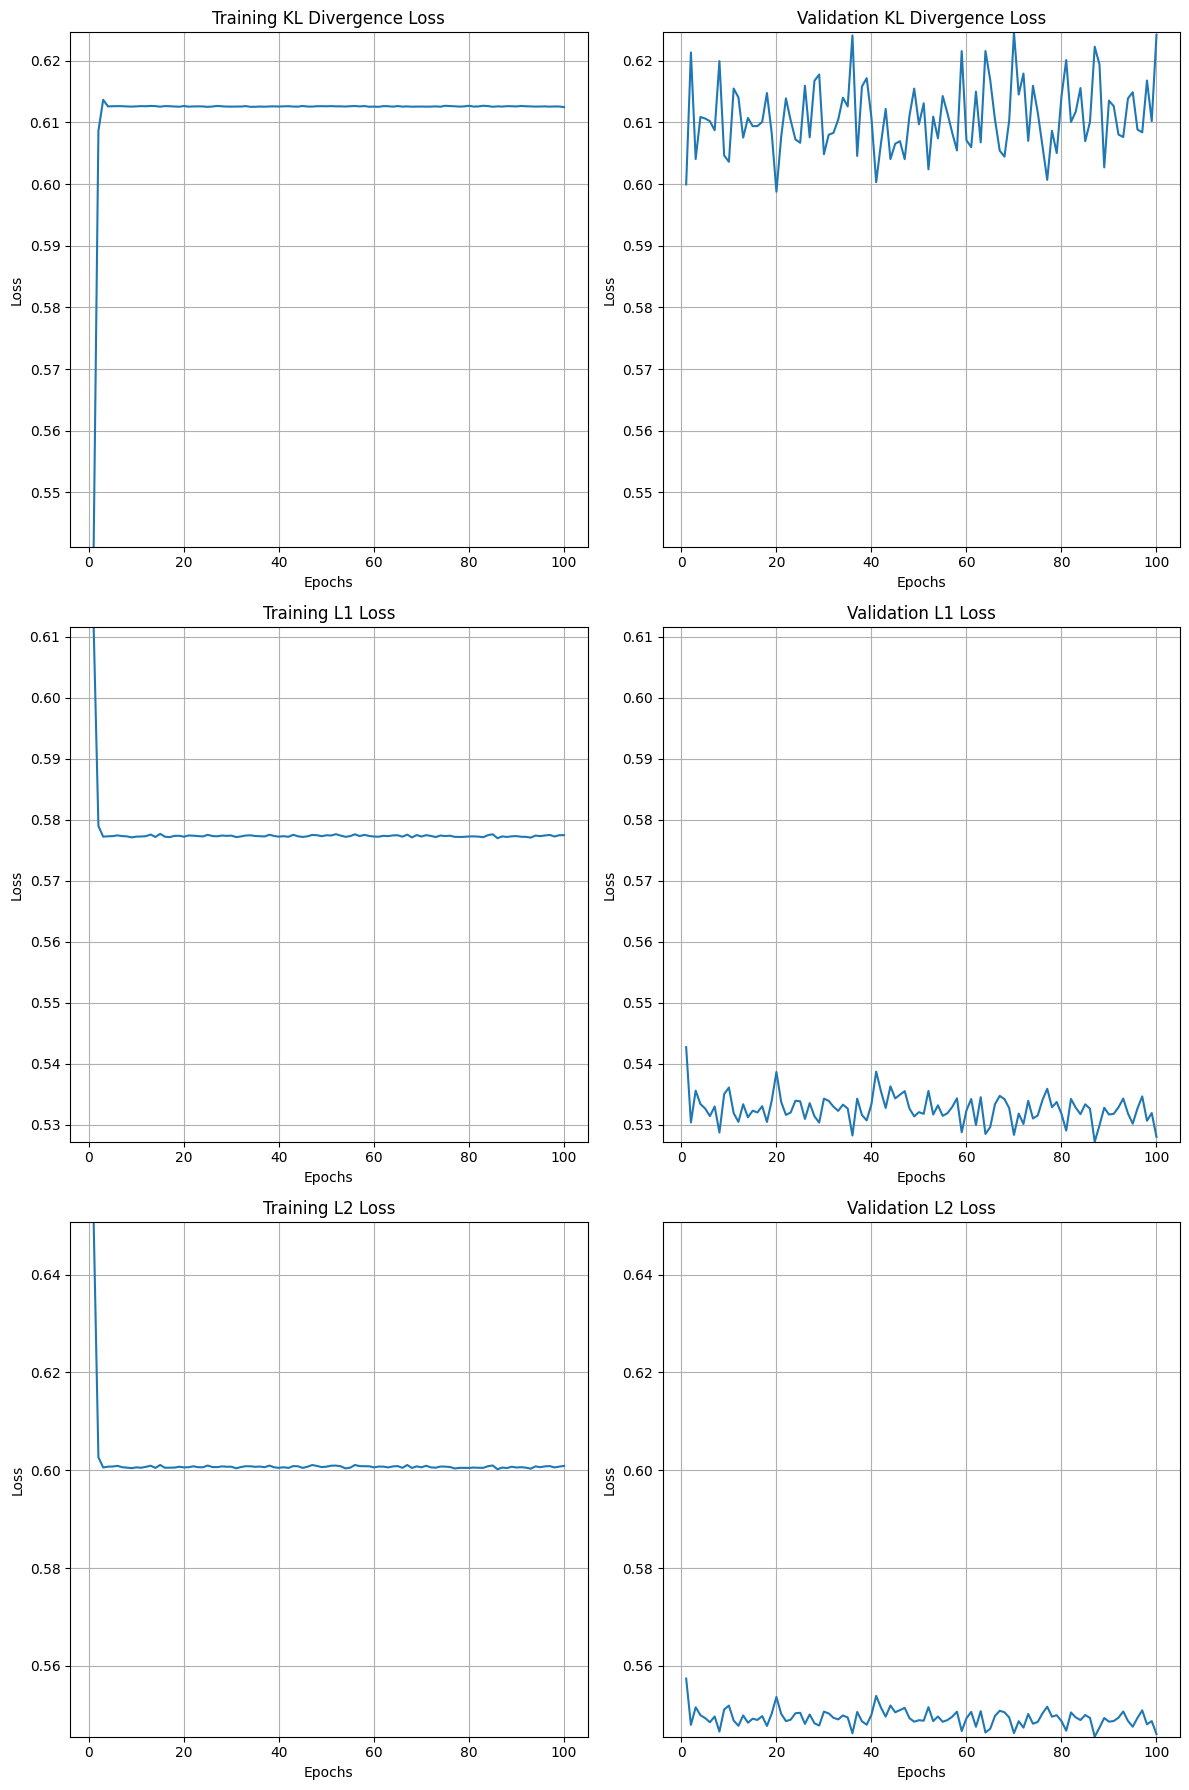

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
53.2487 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


z0: 0.0012
z1: -0.0209
z2: -0.0182
z3: -0.0030


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 712.01it/s]


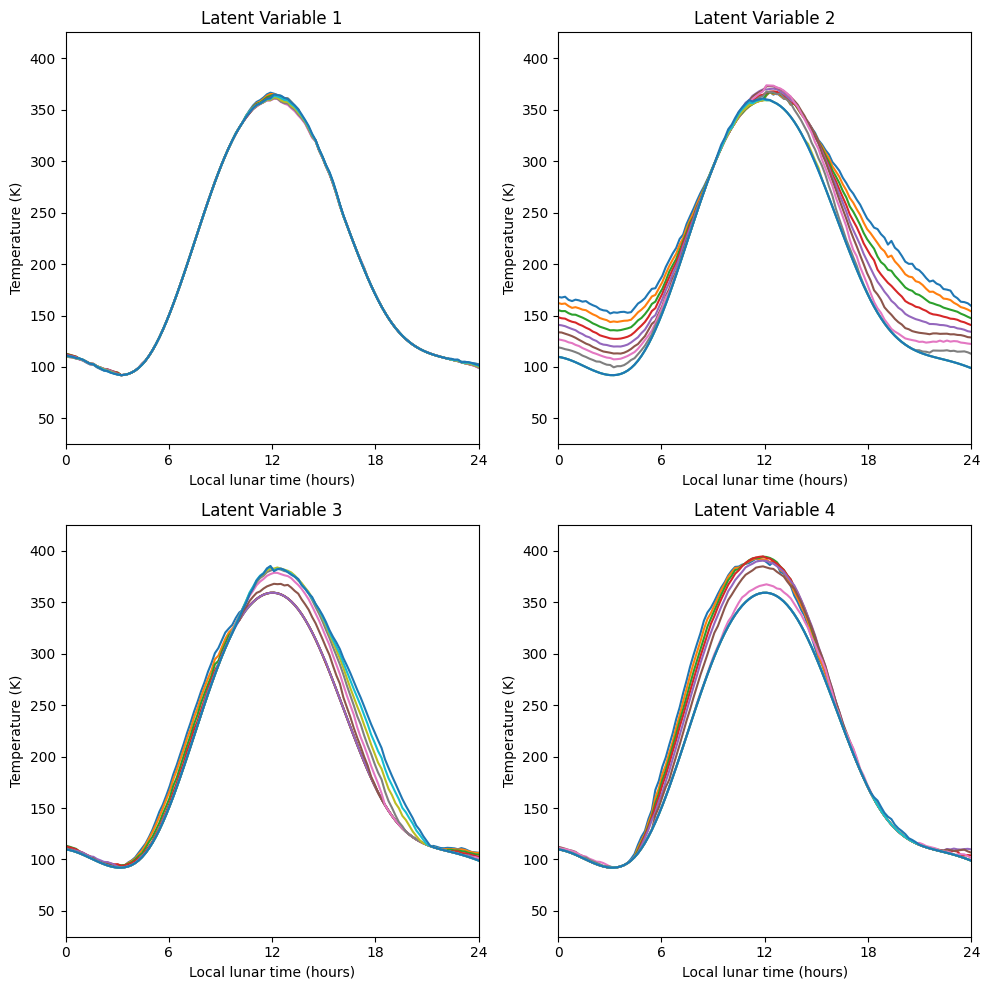

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)